In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [67]:
import pathlib
import random
import time

import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.nn.functional import interpolate
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.transforms.functional import adjust_brightness

from super_resolution.src.sen2venus_dataset import (
    create_train_test_split,
)
from super_resolution.src.visualization import plot_gallery
from super_resolution.src.srgan import SRResNet, Discriminator

In [68]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"
RESULTS_DIR = DATA_DIR / "results"

## Prepare Data

In [69]:
sites = {
    "SO2",
    "FR-BIL",
    "NARYN",
}
train_patches, test_patches = create_train_test_split(
    str(SITES_DIR) + "\\", sites=sites
)
print(f"Num train {len(train_patches)}\n" f"Num test {len(test_patches)}")

Num train 8159
Num test 3498


In [70]:
def image_transform(x, y):
    x = x[:3, :, :]
    y = y[:3, :, :]

    x = torch.clamp(x, 0, 1)
    y = torch.clamp(y, 0, 1)

    return x, y

In [71]:
train_patches.set_transform(image_transform)
test_patches.set_transform(image_transform)

In [72]:
train_loader = DataLoader(train_patches, batch_size=1)

In [73]:
(low_res, high_res) = next(train_loader.__iter__())

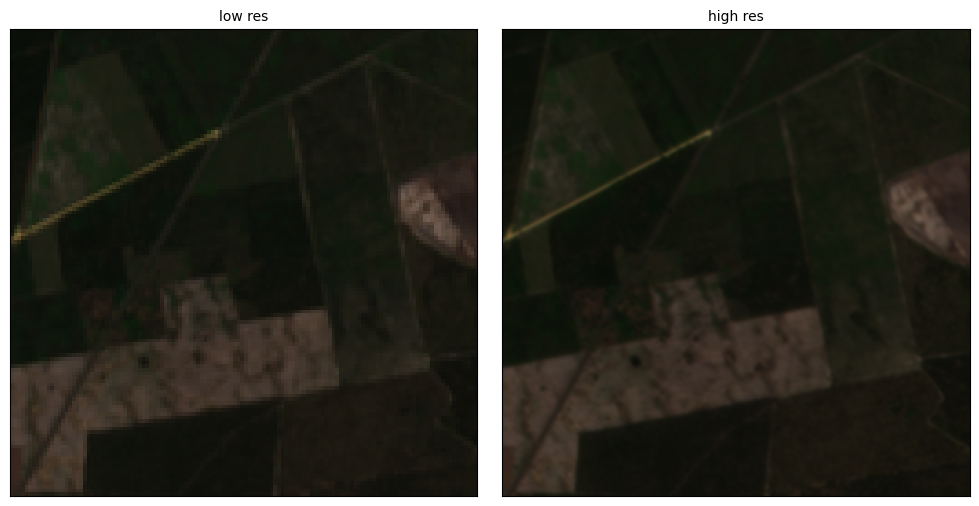

In [74]:
index = random.randint(0, len(low_res) - 1)
low_res_example = low_res[index]


high_res_example = high_res[index]


plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res"],
    xscale=5,
    yscale=5,
)

In [10]:
del train_loader

## Training

In [11]:
# For clearing GPU memory
# 1 / 0

In [11]:
# For clearing GPU memory
import gc

gc.collect()
torch.cuda.empty_cache()

In [12]:
BATCH_SIZE = 16
GEN_LEARNING_RATE = 1e-5
DISCRIM_LEARNING_RATE = 1e-5
GEN_WEIGHT_DECAY = 1e-8
DISCRIM_WEIGHT_DECAY = 1e-8
DISCRIM_WEIGHT = 1e-6

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
should_pin_memory = {"cuda": True, "cpu": False}

train_loader = DataLoader(
    train_patches,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    pin_memory=should_pin_memory[device.type],
    num_workers=0,
)

In [14]:
device

device(type='cuda')

In [31]:
generator = SRResNet(scaling_factor=2, n_blocks=8)

In [36]:
discriminator = Discriminator(n_blocks=2, fc_size=128)

In [105]:
generator = generator.to(device)
generator = generator.train()
discriminator = discriminator.to(device)
discriminator = discriminator.train()

In [38]:
gen_optimizer = optim.Adam(
    generator.parameters(), lr=GEN_LEARNING_RATE, weight_decay=GEN_WEIGHT_DECAY
)

discrim_optimizer = optim.Adam(
    discriminator.parameters(),
    lr=DISCRIM_LEARNING_RATE,
    weight_decay=DISCRIM_WEIGHT_DECAY,
)

In [39]:
save_file = RESULTS_DIR / "greatsrgan_withoutbatchnorm_firstbeatbicubic3_longtrain.pkl"
loaded_experiment = torch.load(save_file, map_location=device)
# generator = SRResNet(scaling_factor=2, n_blocks=16).to(device)
# discriminator = Discriminator(n_blocks=3, fc_size=128)
generator.load_state_dict(loaded_experiment["gen_state"])
discriminator.load_state_dict(loaded_experiment["discrim_state"])
gen_optimizer.load_state_dict(loaded_experiment["gen_optimizer_state"])
discrim_optimizer.load_state_dict(loaded_experiment["discrim_optimizer_state"])
gen_losses = loaded_experiment["gen_losses"]
discrim_losses = loaded_experiment["discrim_losses"]

In [40]:
pixel_criterion = nn.MSELoss()
discrim_criterion = nn.BCEWithLogitsLoss()

In [82]:
NUM_EPOCHS = 2000

In [23]:
train_time = 0.0
gen_losses = []
discrim_losses = []

In [106]:
generator = generator.to(device)
generator = generator.train()
discriminator = discriminator.to(device)
discriminator = discriminator.train()

for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(train_loader, total=len(train_loader), ncols=100)
    gen_epoch_loss = 0.0
    discrim_epoch_loss = 0.0
    num_batches = 0
    for i, (low_res_batch, high_res_batch) in enumerate(progress_bar):
        num_batches += 1
        start_time = time.time()

        # Push to GPU
        low_res_batch = low_res_batch.to(device)
        high_res_batch = high_res_batch.to(device)

        # Update generator
        ############################################################################################
        super_resolved = generator(low_res_batch)
        natural_probs = discriminator(super_resolved)

        pixel_loss = pixel_criterion(super_resolved, high_res_batch)
        adversarial_loss = discrim_criterion(
            natural_probs, torch.ones_like(natural_probs)
        )
        gen_loss = pixel_loss

        gen_loss += DISCRIM_WEIGHT * adversarial_loss

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # Update discriminator
        ############################################################################################
        true_natural_probs = discriminator(high_res_batch)

        # Detach to skip generator computations
        fake_natural_probs = discriminator(super_resolved.detach())

        true_natural_loss = discrim_criterion(
            true_natural_probs, torch.ones_like(true_natural_probs)
        )
        fake_natural_loss = discrim_criterion(
            fake_natural_probs, torch.zeros_like(fake_natural_probs)
        )
        discrim_loss = true_natural_loss + fake_natural_loss

        discrim_optimizer.zero_grad()
        discrim_loss.backward()
        discrim_optimizer.step()

        # Collect data
        gen_epoch_loss += gen_loss.item()
        discrim_epoch_loss += discrim_loss.item()
        progress_bar.set_postfix(
            epoch=epoch,
            gen_loss=f"{gen_epoch_loss/num_batches:.8f}",
            discrim_loss=f"{discrim_epoch_loss/num_batches:.8f}",
        )

        end_time = time.time()
        train_time += end_time - start_time

    gen_epoch_loss /= len(train_loader)
    discrim_epoch_loss /= len(train_loader)
    gen_losses.append(gen_epoch_loss)
    discrim_losses.append(discrim_epoch_loss)
    print(
        f"Epoch: {epoch} / gen_loss: {gen_epoch_loss:.8f} / discrim_loss: {discrim_epoch_loss:.8f}"
    )

100%|████| 8159/8159 [13:21<00:00, 10.18it/s, discrim_loss=1.35452068, epoch=0, gen_loss=0.00003814]


Epoch: 0 / gen_loss: 0.00003814 / discrim_loss: 1.35452068


 13%|▌   | 1058/8159 [01:45<11:51,  9.98it/s, discrim_loss=1.33195251, epoch=1, gen_loss=0.00004145]


KeyboardInterrupt: 

In [107]:
train_time / 60

9.9088924686114

In [108]:
len(gen_losses)

75

In [109]:
gen_losses[-5:]

[2.9749825356459778e-05,
 2.9606988012798915e-05,
 2.9742742072349903e-05,
 4.1806910115257686e-05,
 3.8141459667669176e-05]

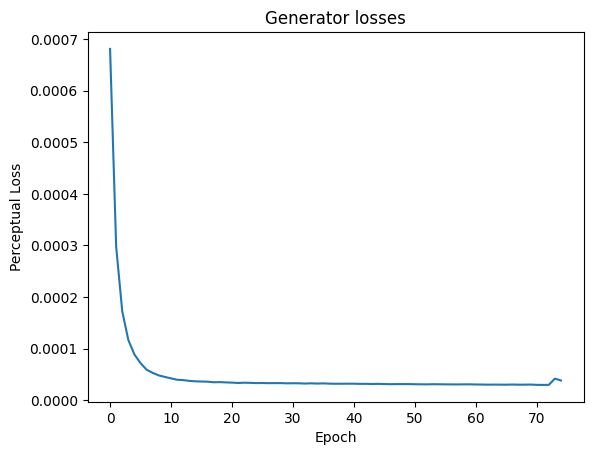

In [110]:
plt.plot(gen_losses)
plt.title("Generator losses")
plt.xlabel("Epoch")
plt.ylabel("Perceptual Loss")
plt.show()

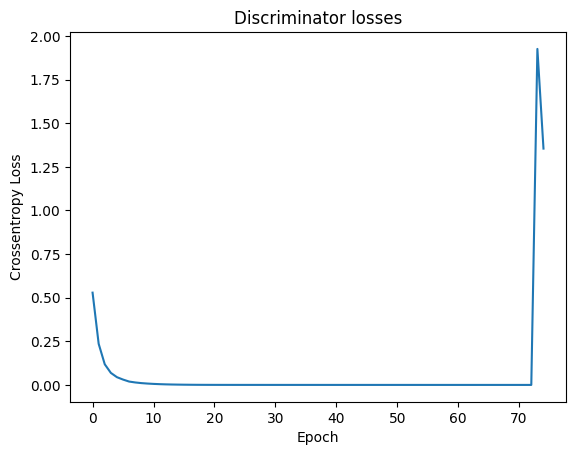

In [111]:
plt.plot(discrim_losses)
plt.title("Discriminator losses")
plt.xlabel("Epoch")
plt.ylabel("Crossentropy Loss")
plt.show()

## Saving

In [131]:
experiment = {
    "gen_losses": gen_losses,
    "discrim_losses": discrim_losses,
    "gen_state": generator.state_dict(),
    "discrim_state": discriminator.state_dict(),
    "gen_optimizer_state": gen_optimizer.state_dict(),
    "discrim_optimizer_state": discrim_optimizer.state_dict(),
    "gen_learning_rate": GEN_LEARNING_RATE,
    "discrim_learning_rate": DISCRIM_LEARNING_RATE,
    "gen_weight_decay": GEN_WEIGHT_DECAY,
    "discrim_weight_decay": DISCRIM_WEIGHT_DECAY,
    "discrim_weight": DISCRIM_WEIGHT,
    "train_time": train_time,
}

In [132]:
save_file = RESULTS_DIR / "continuingbestgen_2epoch.pkl"

In [133]:
if not save_file.exists():
    torch.save(experiment, save_file)
    print(f"Saved to {save_file}")

Saved to C:\Users\Mitch\stat3007_data\results\continuingbestgen_2epoch.pkl


## Generated Examples

In [112]:
generator = generator.to("cpu")

In [113]:
loader = DataLoader(train_patches, batch_size=100)
(low_res, high_res) = next(loader.__iter__())

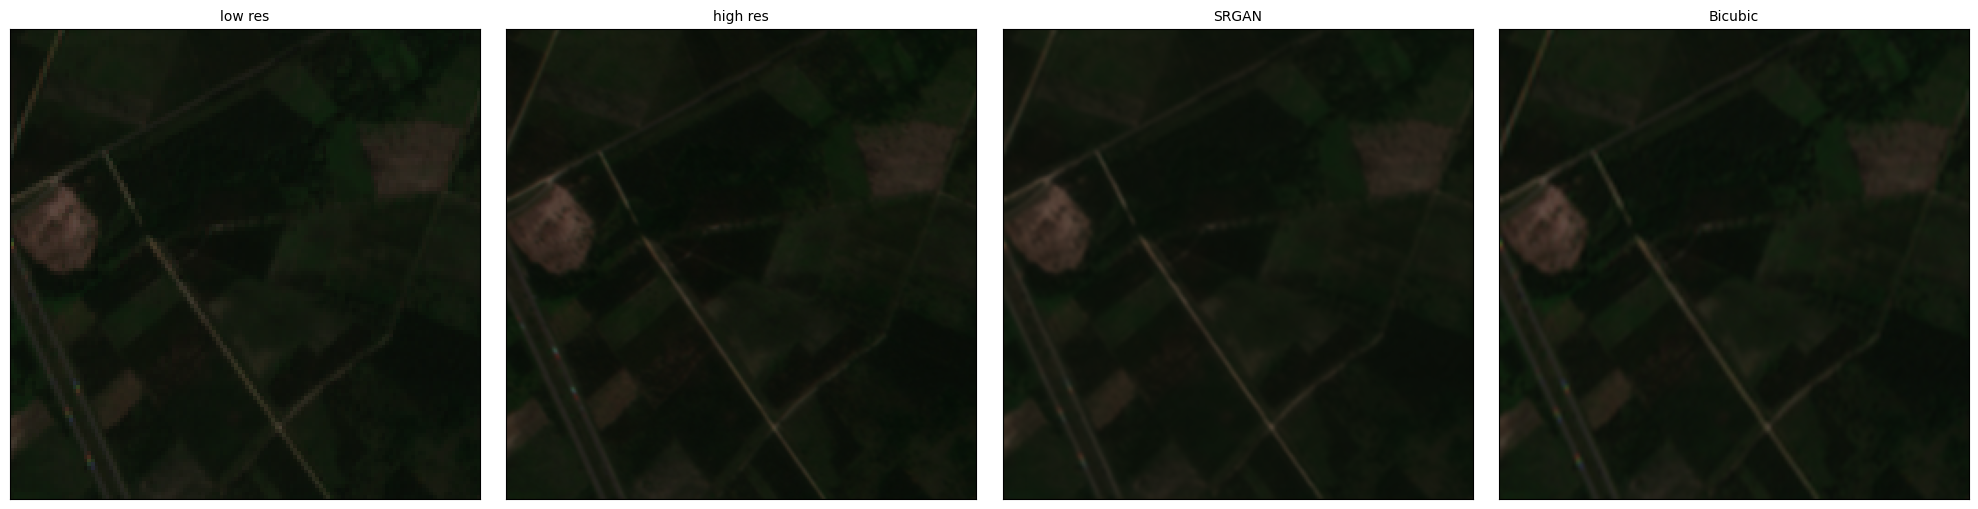

In [121]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]
out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)
bicubic_out = interpolate(
    low_res_example.unsqueeze(0),
    size=(256, 256),
    mode="bicubic",
).float()
plot_gallery(
    [
        adjust_brightness(low_res_example, 2).permute(1, 2, 0),
        adjust_brightness(high_res_example, 2).permute(1, 2, 0),
        adjust_brightness(out[0], 2).permute(1, 2, 0),
        adjust_brightness(bicubic_out[0], 2).permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

In [123]:
loader = DataLoader(test_patches, batch_size=300)
(low_res, high_res) = next(loader.__iter__())

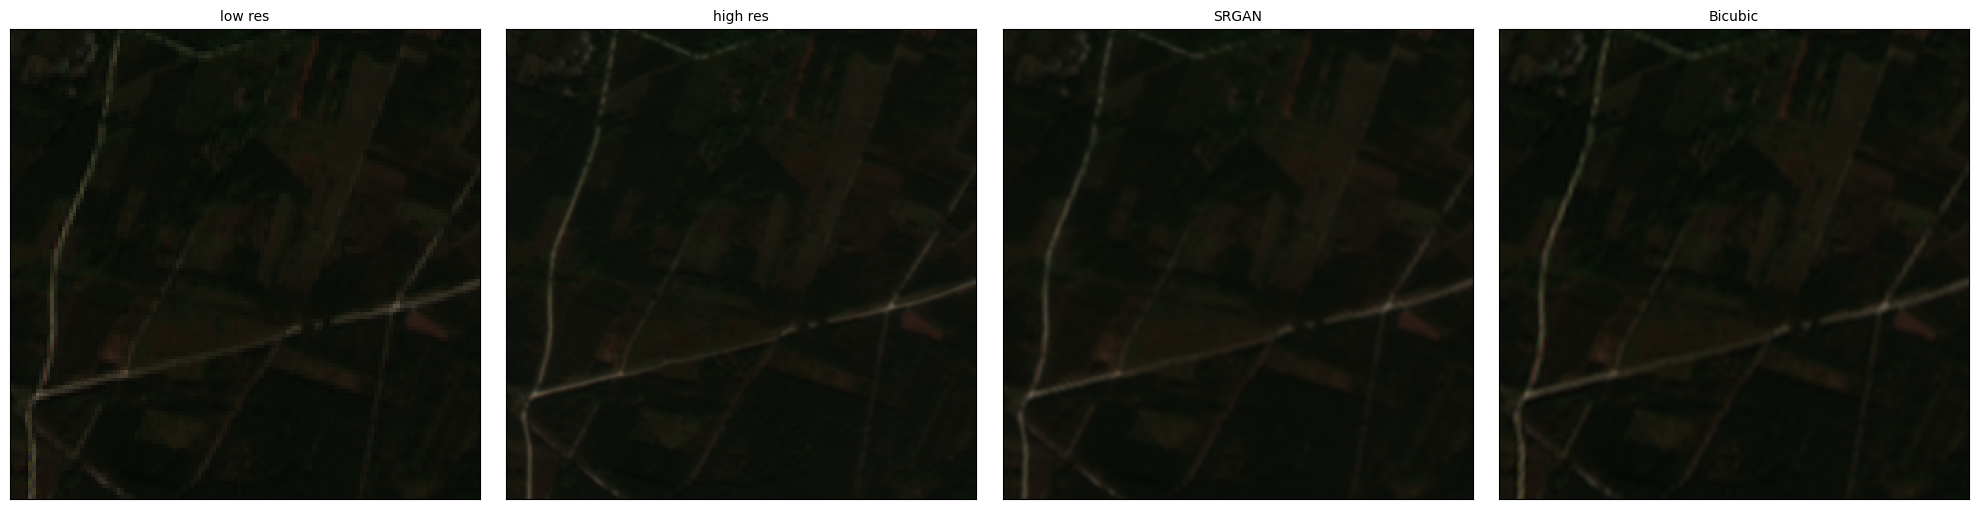

In [125]:
import random

index = random.randint(0, len(low_res) - 1)

low_res_example = low_res[index]
high_res_example = high_res[index]

out = generator(low_res_example.unsqueeze(0)).detach().clamp(0, 1)[0]
out = adjust_brightness(out, 2)

bicubic_out = (
    interpolate(low_res_example.unsqueeze(0), size=(256, 256), mode="bicubic")
    .float()
    .clamp(0, 1)
)[0]
bicubic_out = adjust_brightness(bicubic_out, 2)

low_res_example = adjust_brightness(low_res_example, 2)
high_res_example = adjust_brightness(high_res_example, 2)

plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        high_res_example.permute(1, 2, 0),
        out.permute(1, 2, 0),
        bicubic_out.permute(1, 2, 0),
    ],
    titles=["low res", "high res", "SRGAN", "Bicubic"],
    xscale=5,
    yscale=5,
)

## Save images

In [ ]:
IMAGE_DIR = RESULTS_DIR / "images"

In [ ]:
index

In [ ]:
srgan_file = IMAGE_DIR / f"{index}srgan.png"
bicubic_file = IMAGE_DIR / f"{index}bicubic.png"
low_res_file = IMAGE_DIR / f"{index}lowres.png"
high_res_file = IMAGE_DIR / f"{index}highres.png"

In [ ]:
save_image(low_res_example, low_res_file)
save_image(high_res_example, high_res_file)
save_image(out, srgan_file)
save_image(bicubic_out, bicubic_file)

## Metrics

In [126]:
del loader

In [127]:
from super_resolution.src.testing import compute_metrics

In [128]:
# 256 is largest I can handle on cpu
metric_loader = DataLoader(test_patches, batch_size=min(len(test_patches), 256))

In [129]:
metrics = compute_metrics(lambda x: generator(x).clamp(0, 1), metric_loader)

100%|███████████████████████████████████████████████████████████████| 14/14 [15:36<00:00, 66.90s/it]


In [130]:
metrics

Metrics(mse=3.480387333963465e-05, psnr=44.59234128679548, ssim=0.9862964749336243, fid=1.0090789794921875)

In [ ]:
metrics

Metrics(mse=5.6361801658308e-05, psnr=42.49327768598284, ssim=0.9817832069737571, fid=2.9706573486328125)

In [79]:
bicubic_metrics = compute_metrics(
    lambda x: interpolate(x, size=(256, 256), mode="bicubic"), metric_loader
)

100%|███████████████████████████████████████████████████████████████| 14/14 [09:37<00:00, 41.28s/it]


In [80]:
bicubic_metrics

Metrics(mse=4.024813668885534e-05, psnr=43.96280016217913, ssim=0.9836511441639492, fid=1.3964385986328125)